In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.utils import shuffle
import re

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from textblob import TextBlob
from nltk import tokenize


In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\karao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\karao\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [4]:
df.drop_duplicates(subset ="Reviews", keep = "first", inplace = True)

In [5]:
df.shape

(162492, 6)

In [6]:
df['Reviews'] = df['Reviews'].astype('str')

In [7]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity


df['Polarity'] = df['Reviews'].apply(get_polarity)

In [8]:
df['Sentiment_Type']=''
df.loc[df.Polarity>0,'Sentiment_Type']='POSITIVE'
df.loc[df.Polarity==0,'Sentiment_Type']='NEUTRAL'
df.loc[df.Polarity<0,'Sentiment_Type']='NEGATIVE'

In [9]:
df['Sentiment_Type'].value_counts()

POSITIVE    119105
NEGATIVE     23677
NEUTRAL      19710
Name: Sentiment_Type, dtype: int64

<AxesSubplot:title={'center':'Sentiment Analysis'}>

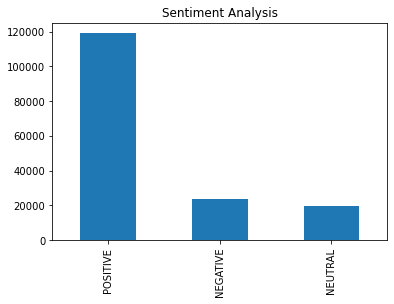

In [10]:
df.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")

In [11]:

import re
import string

#küçük harfe yapar ve noktlma işartelrini kaldırır
def text_clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

cleaned = lambda x: text_clean(x)

In [12]:
# Let's take a look at the updated text
import pandas
df['Reviews'] = pd.DataFrame(df.Description.apply(cleaned))
df.head(10)

AttributeError: 'DataFrame' object has no attribute 'Description'

In [ ]:
df.dropna(inplace=True)
df[df['Rating'] != 3]
df['Positively Rated'] = np.where(df['Rating'] > 3, 1, 0)
df.head(10)

In [17]:
df['Positively Rated'].mean()

KeyError: 'Positively Rated'

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Positively Rated'], random_state = 0) #Polarity Positively Rated

KeyError: 'Positively Rated'

In [20]:
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

KeyError: 0

In [21]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(X_train)

In [22]:
vect.get_feature_names()[::3000]

['00',
 '81i',
 'appearances',
 'blurry',
 'classifieds',
 'dalete',
 'duly',
 'fanboy',
 'gottin',
 'includedgreat',
 'leaked',
 'misrepresentation',
 'oneor',
 'poderia',
 'receipient',
 'saynetworking',
 'sparkle',
 'thanactually',
 'unwanted',
 'woulod']

In [23]:
len(vect.get_feature_names())

57998

In [24]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<121869x57998 sparse matrix of type '<class 'numpy.int64'>'
	with 4052593 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

ValueError: Unknown label type: 'continuous'

In [ ]:
from sklearn.metrics import roc_auc_score

predictions = model.predict(vect.transform(X_test))

print('AUC: ', roc_auc_score(y_test, predictions))

In [ ]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [ ]:
#Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df = 5).fit(X_train)
len(vect.get_feature_names())

In [ ]:
X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

In [ ]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()

print('Smallest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

In [ ]:
sorted_coef_index = model.coef_[0].argsort()

print('Smallest coef: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest coef: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [ ]:
# These reviews are treated the same by our current model

print(model.predict(vect.transform(['Not an issue, phone is working', 
                                   'an issue, phone is not working'])))

In [ ]:
# n-grams
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df = 5, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
len(vect.get_feature_names())

In [ ]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

In [ ]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:10]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-11:-1]))

In [ ]:
print(model.predict(vect.transform(['not an issue, phone is working',
                                   'an issue, phone is not working'])))